# FAIP Themes: NLP - Assignment

---

In this assignement we will be focusing on natural language processing (**NLP**), specifically, on **text representations** and how to use them.

The objectives of this assignment are:

- Applying representation techniques to train text classifiers.
- Loading and using existing pre-trained static word embeddings.
- Using contextual embeddings from neural pre-trained Transformer models.

## Instructions

- Create text cells to explain the steps of your solution to this assignment.
- Print the notebook as a pdf file and save it with your group ID/name for the submission as `FAIP_NLP_assignment_<group>.pdf`.

## Requirements

For this assignment you'll need the following packages installed:


In [1]:
!pip install numpy scikit-learn matplotlib datasets nltk transformers

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00


Notes:
- you should create a separate python environment for this assignment. You can follow this guides on how to do it with either [virtual environments](https://realpython.com/python-virtual-environments-a-primer/) or [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html) or
- if you get a compatiblity error regarding `pyarrow` but the installation of the packages completes successfully, you can still proceed with the assignment.

## Downloading GloVe Embeddings

[GloVe](https://nlp.stanford.edu/projects/glove/) is a technique to obtain word representations from large unsupervised text corpora. We will use a set of pre-trained word embeddings for this task that is provided by the authors and can be downloaded.

Run the following cell to download and extract the GloVe embeddings (this needs to be done only once). These embeddings were trained on a total of 6 billion text tokens.

Note: *the 6B embeddings are only a few hundred megabytes but it might still take some time to download.*

In [2]:
from urllib.request import urlretrieve
from shutil import unpack_archive

urlretrieve("https://nlp.stanford.edu/data/wordvecs/glove.6B.zip", "glove.6B.zip")
unpack_archive("glove.6B.zip", "glove.6B")

At this point, you should find a new folder (`glove.6B`) in the same directory as this notebook. Inside this folder, there are multiple text files, each of which corresponds to a set of embeddings, but the dimensionality of the vectors varies (`50`, `100`, `200`, and `300`).

Remember, the dimensionality of the embeddings has a direct impact on the number of word relations that can be captured.

For example, the file corresponding to `300`-dimensional vectors can be parsed like this:


In [3]:
from pathlib import Path

glove_300d = Path("glove.6B") / "glove.6B.300d.txt"
with open(glove_300d) as fp:
    for line in fp:
        row = line.split()
        word = row[0]
        vec = row[1:]
        print(word, "\t", vec)
        break

the 	 ['0.04656', '0.21318', '-0.0074364', '-0.45854', '-0.035639', '0.23643', '-0.28836', '0.21521', '-0.13486', '-1.6413', '-0.26091', '0.032434', '0.056621', '-0.043296', '-0.021672', '0.22476', '-0.075129', '-0.067018', '-0.14247', '0.038825', '-0.18951', '0.29977', '0.39305', '0.17887', '-0.17343', '-0.21178', '0.23617', '-0.063681', '-0.42318', '-0.11661', '0.093754', '0.17296', '-0.33073', '0.49112', '-0.68995', '-0.092462', '0.24742', '-0.17991', '0.097908', '0.083118', '0.15299', '-0.27276', '-0.038934', '0.54453', '0.53737', '0.29105', '-0.0073514', '0.04788', '-0.4076', '-0.026759', '0.17919', '0.010977', '-0.10963', '-0.26395', '0.07399', '0.26236', '-0.1508', '0.34623', '0.25758', '0.11971', '-0.037135', '-0.071593', '0.43898', '-0.040764', '0.016425', '-0.4464', '0.17197', '0.046246', '0.058639', '0.041499', '0.53948', '0.52495', '0.11361', '-0.048315', '-0.36385', '0.18704', '0.092761', '-0.11129', '-0.42085', '0.13992', '-0.39338', '-0.067945', '0.12188', '0.16707', '0.

**In this assignment, we will use the `300`-dimensional embeddings.**
You can explore the other embeddings at your own pace.

Let's load and parse the `300`-dimensional embeddings:


In [4]:
import numpy as np

vectors, words, word_to_idx = [], [], {}

with open(glove_300d, 'r', encoding='utf-8') as fp:
    for i, line in enumerate(fp):
        row = line.split()
        word_to_idx[row[0]] = i
        words.append(row[0])
        vectors.append(row[1:])

vectors = np.array(vectors, dtype=np.float32)

If everything was successful, the following checks (read about Python assertions [here](https://www.w3schools.com/python/ref_keyword_assert.asp)) should not raise errors:


In [5]:
assert vectors.shape == (
    400001,
    300,
), "400001 300-dimensional embeddings should have been loaded."
assert words[0] == "the", "Expected to find 'the' as the first token."
assert word_to_idx["the"] == 0, "Expected to find 0 as ID for token 'the'."

## Task 1 - Visualization

Your first task is to **visualize** the word embeddings we just loaded **in 2D**. Since the vectors are `300`-dimensional and the plot should be two-dimensional, you'll need to use a **dimensionality reduction technique**. Specifically:

1. Fit a principal component analysis (PCA) model to the entire array of word embedding vectors. Use `2` components. You can use [the scikit-learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for this.
2. Randomly select `200` words and their corresponding embeddings. You can use [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) for this.
3. Transform the selected embeddings using your PCA model and plot them in a two-dimensional scatter plot. Display the corresponding word next to each point. You can use [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) for this.


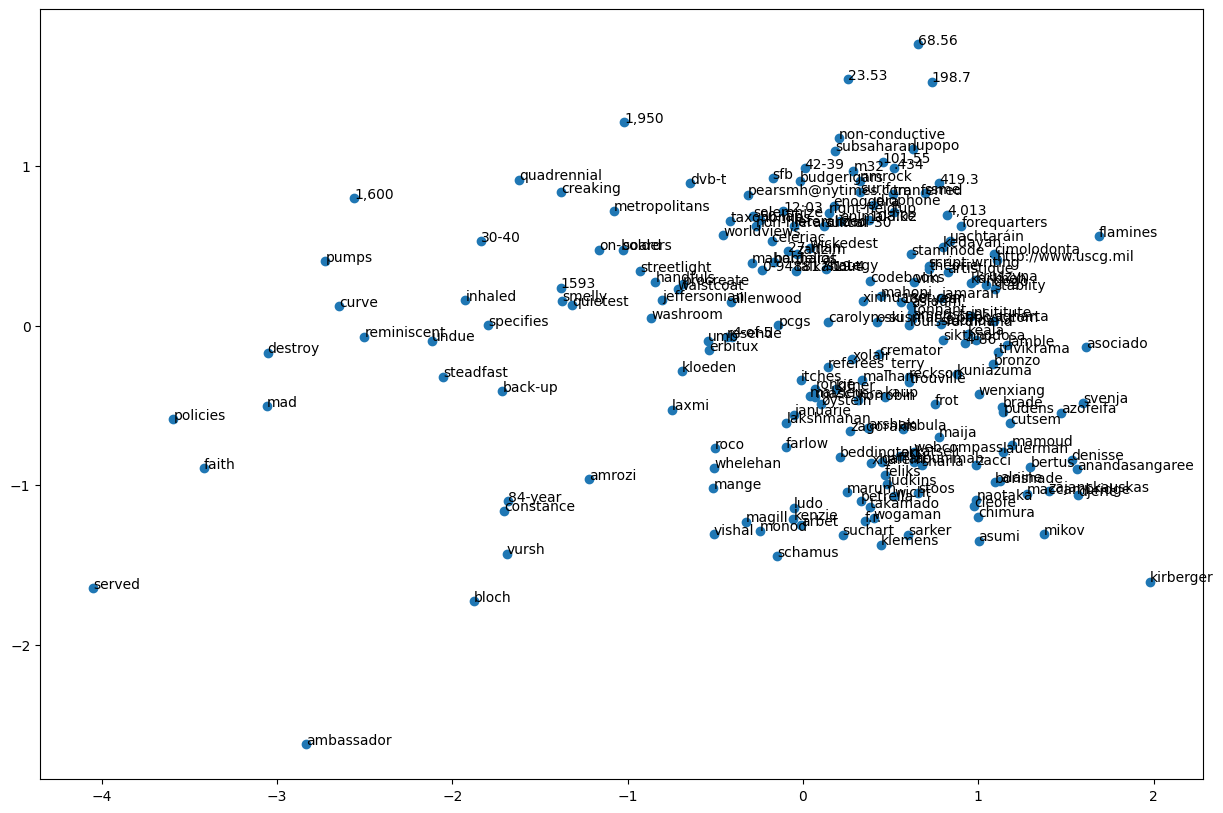

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TODO
pca = PCA(n_components=2)
pca.fit(vectors)

random200wordsIdx = np.random.choice(len(words), size=200)
random200words = np.array(words)[random200wordsIdx]
random200wordsVectors = vectors[random200wordsIdx]


random200wordsVectors_pca = pca.transform(random200wordsVectors)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(random200wordsVectors_pca[:, 0], random200wordsVectors_pca[:, 1])
for i, txt in enumerate(random200words):
    ax.annotate(txt, (random200wordsVectors_pca[i, 0], random200wordsVectors_pca[i, 1]))

plt.show()

## Task 2 - Word Semantics

The plot above should have given you an idea how word embeddings are distributed in the vector space. We now exploit the semantic information these embeddings possess to find **similar words**:

1. Implement the function `get_similar_words` below. Given a `word`, the function returns a list of `n` words from the vocabulary which are most similar to it accoding to the word embeddings.
2. Print the `5` most similar words to `banana`.


In [20]:
def get_similar_words(word: str, n: int = 5) -> list[str]:
    wordIdx = word_to_idx[word]
    wordVector = vectors[wordIdx]

    similarity = np.dot(vectors, wordVector) / (np.linalg.norm(vectors) * np.linalg.norm(wordVector))

    similarWordsIdx = np.argsort(similarity)[::-1][1:n+1]
    similarWords = np.array(words)[similarWordsIdx]

    return similarWords

print(get_similar_words("banana"))

['bananas' 'pineapple' 'coconut' 'mango' 'papaya']


## Task 3 - Sentiment Classification

Now we will use the word embeddings to perform a downstream task, in this case, **sentiment classification** of movie reviews.

- Data: We use the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) which contains movie reviews and corresponding labels (negative/positive).
- Model: We build a sentiment classifier based on word embeddings and support vector machines (SVMs).

The dataset is [available on the Hugging Face Hub](https://huggingface.co/datasets/stanfordnlp/imdb) and can be loaded as follows:


In [21]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

This dataset is split into training and test instances, which can be accessed using `ds["train"]` and `ds["test"]`, respectively. Furthermore, you can use `ds["train"]["text"]` and `ds["train"]["label"]` to access the reviews and corresponding labels.

1. Implement the function `get_glove_representation`. Given a `text` (here: a movie review), this function
   - converts the text to lower case,
   - tokenizes the text (i.e., splits it into words),
   - removes stopwords and punctuation,
   - represents each word (token) as its embedding (if a token is not in the vocabulary, the `<unk>` token should be used instead),
   - returns the average of all token representations within the text.

You can use [NLTK](https://www.nltk.org/) for tokenization and stopword removal.


In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")


def get_glove_representation(text: str) -> np.ndarray:
    # TODO
    text = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    cleaned_tokens = [word for word in tokens if word not in stopwords.words("english")]

    word_vectors = []
    for word in cleaned_tokens:
        if word in word_to_idx:
            word_vectors.append(vectors[word_to_idx[word]])
        else:
            word_vectors.append(vectors[word_to_idx["unk"]])

    return np.mean(word_vectors, axis=0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Fit and evaluate a [support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) on the data. Use [`classification_report`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html) for evaluation.


In [106]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# TODO
X_train = np.array([get_glove_representation(text) for text in ds["train"]["text"]])
y_train = np.array(ds["train"]["label"])

X_test = np.array([get_glove_representation(text) for text in ds["test"]["text"]])
y_test = np.array(ds["test"]["label"])




In [108]:
svc = SVC(kernel = 'linear')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

ValueError: The number of classes has to be greater than one; got 1 class

## Task 4 - Neural Models

In this final task, we'll see how word embeddings compare to modern neural contextual classification models based on Transformers. We'll load a [pre-trained model from the Hugging Face Hub](https://huggingface.co/AdamCodd/tinybert-sentiment-amazon) based on TinyBERT which has been fine-tuned for sentiment classification:


In [45]:
from transformers import pipeline

tinybert_sentiment_classifier = pipeline(
    "text-classification",
    model="AdamCodd/tinybert-sentiment-amazon",
    max_length=512,
    truncation=True,
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

This pipeline can be used as follows:


In [46]:
tinybert_sentiment_classifier("this movie was great")

[{'label': 'positive', 'score': 0.9902142286300659}]

1. Evaluate the neural sentiment classifier on the same data as the SVC before. Which model performs better?

**No training or fine-tuning is required for this task.**


In [62]:
# TODO
y_pred = [tinybert_sentiment_classifier(text)[0]["label"] for text in ds["test"]["text"]]
encoding = {"positive": 1, "negative": 0}
y_pred = [encoding[label] for label in y_pred]

y_test = ds["test"]["label"]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.00      0.00      0.00         0

    accuracy                           0.70        10
   macro avg       0.50      0.35      0.41        10
weighted avg       1.00      0.70      0.82        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
